# 1  Automated data cleaning for chest Xrays with cleanX: notebook for medical professionals with limited coding abililties. 

CleanX is a code library by Candace Makeda Moore, MD, Oleg Sivokon, and Andrew Murphy. Please note this workflow does not cover the whole scope of cleanX, and is only meant to show one part of the functionality that can be accomplished using cleanX. While cleanX has functions for processing dicoms, and datasets, this notebook focuses on some of what it can do with images.

The purpose of this notebook is to educate people with very limited understanding of machine learning and code about some of what cleanX does, and why it is worth incorporating it into use. The real efficiency of cleanX happens when it works with classes and in a pipeline, however, this notebook shows functions in a simple way, and therefore should be read the notebook with classes by anyone who truly wants to understand the power of cleanx.

In [1]:
# # importing the latest cleanX from my own machine
# # identical to develop branch on 26/2/2022

import sys
sys.path = ['D:/projects/cleanX'] + sys.path

In [2]:
# we will need to import some libraries
import pandas as pd
import os
import cv2
import numpy as np
from cleanX import (
    dataset_processing as csvp,
    dicom_processing as dicomp,
    image_work as iwork,
)

Reading and analysis of chest X-rays is a common task in hospitals. In fact in many hospitals so many chest X-rays are performed that some are never read, and some are only read by people with limited training in radiology. Some countries have a very limited number of radiologists so radiographers read the chest X-rays. Regardless of who reads these images, they can be difficult to interpret and the error rate is reported as high in the medical literature (over 10% or even over 15% depending upon the source). Machine learning based algorithms have the potential to improve this situation in a variety of ways, however machine learning algorithms are powered by mountains of labeled data. And this need for labeled data creates a potential problem. 

Labeled data must either be retrieved from existing read X-rays (errors included), or created by humans (already over-burdened with reading X-rays, actually that was the original problem in the first place, right?). Several groups have created big datasets that algorithms can be trained on, but no dataset is perfect for every task. Unfortunately many datasets contain images that may not be appropriate to make a machine learning algorithm from. As a case in point, let's take a look at some of the data in a large set of COVID-19 images. We will use the CoronaHack -Chest X-Ray-Dataset from Kaggle (https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset). The dataset was assembled by Praveen Govindaraj. This dataset has thousands of images ( 5,309 images to be exact)...too many to look through by hand without wasting a lot of time

Unfortunately, keeping 40 gigabytes of image data on Github is not possible or a good idea. 
If you want to get these images onto your computer, you basically need tosign into Kaggle, and download. There is no way to download without credentials at present. You can however download if you have the API client, and an example cell has been added for this:

In [3]:
# If you have the kaggle API client you can run a download
# to get the API from connda: conda install -c conda-forge kaggle
!kaggle datasets download praveengovi/coronahack-chest-xraydataset --unzip
origin_folder = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'


  0%|          | 0.00/1.19G [00:00<?, ?B/s]
  0%|          | 1.00M/1.19G [00:00<02:01, 10.5MB/s]
  0%|          | 4.00M/1.19G [00:00<01:14, 17.1MB/s]
  0%|          | 6.00M/1.19G [00:00<01:11, 17.8MB/s]
  1%|          | 8.00M/1.19G [00:00<01:09, 18.2MB/s]
  1%|          | 10.0M/1.19G [00:00<01:09, 18.2MB/s]
  1%|          | 12.0M/1.19G [00:00<01:11, 17.6MB/s]
  1%|1         | 15.0M/1.19G [00:00<01:08, 18.4MB/s]
  1%|1         | 18.0M/1.19G [00:01<01:02, 20.1MB/s]
  2%|1         | 20.0M/1.19G [00:01<01:02, 20.1MB/s]
  2%|1         | 22.0M/1.19G [00:01<01:15, 16.7MB/s]
  2%|2         | 26.0M/1.19G [00:01<01:00, 20.8MB/s]
  2%|2         | 29.0M/1.19G [00:01<01:06, 18.7MB/s]
  3%|2         | 32.0M/1.19G [00:01<00:59, 21.0MB/s]
  3%|2         | 35.0M/1.19G [00:01<00:58, 21.0MB/s]
  3%|3         | 38.0M/1.19G [00:02<00:57, 21.3MB/s]
  3%|3         | 41.0M/1.19G [00:02<01:03, 19.6MB/s]
  4%|3         | 43.0M/1.19G [00:02<01:09, 17.7MB/s]
  4%|3         | 47.0M/1.19G [00:02<00:56, 21.6MB/s]
 

Alternatively you can point, click download and put the folder somewhere as illustrated below.

In [4]:
# here I pull the images off my personal rive 
origin_folder ='D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'    


 36%|###5      | 432M/1.19G [00:22<00:34, 23.9MB/s]
 36%|###5      | 435M/1.19G [00:22<00:32, 25.0MB/s]
 36%|###6      | 438M/1.19G [00:22<00:33, 24.4MB/s]
 36%|###6      | 441M/1.19G [00:22<00:32, 25.2MB/s]
 36%|###6      | 444M/1.19G [00:22<00:36, 22.3MB/s]
 37%|###6      | 447M/1.19G [00:23<00:34, 23.7MB/s]
 37%|###6      | 450M/1.19G [00:23<00:32, 24.7MB/s]
 37%|###7      | 453M/1.19G [00:23<00:34, 23.0MB/s]
 37%|###7      | 456M/1.19G [00:23<00:36, 22.0MB/s]
 38%|###7      | 459M/1.19G [00:23<00:32, 24.1MB/s]
 38%|###7      | 462M/1.19G [00:23<00:32, 24.6MB/s]
 38%|###8      | 465M/1.19G [00:23<00:31, 24.7MB/s]
 38%|###8      | 468M/1.19G [00:24<00:50, 15.7MB/s]
 39%|###8      | 472M/1.19G [00:24<00:39, 19.7MB/s]
 39%|###9      | 475M/1.19G [00:24<00:37, 20.5MB/s]
 39%|###9      | 478M/1.19G [00:24<00:36, 21.3MB/s]
 40%|###9      | 481M/1.19G [00:24<00:35, 21.7MB/s]
 40%|###9      | 484M/1.19G [00:24<00:35, 21.8MB/s]
 40%|####      | 487M/1.19G [00:25<00:33, 23.0MB/s]
 40%|####  

## Finding duplicates
We may or may not want to use duplicated images to build an algorithm. Generally, it's a bad idea. At the extreme, if all of one pathology is simply duplicated images, we do not have enough data. Instead of trying to remember if we see duplicates in thousands of images, let's ask cleanX. cleanX can compare the images pixel by pixel, but this takes time if you don't have a powerful computer, even though it doesn't take human time. We could take a much needed break, but to speed the computer time up it is reccomended to use a hash based comparison as below:

First we will make the dataframe and see how many images are in it:

In [5]:
phasion_df = iwork.cv2_phash_for_dupes(origin_folder)
len(phasion_df)


 65%|######4   | 790M/1.19G [00:40<00:23, 18.7MB/s]
 65%|######5   | 792M/1.19G [00:40<00:34, 13.1MB/s]
 66%|######5   | 800M/1.19G [00:40<00:19, 21.9MB/s]
 66%|######6   | 803M/1.19G [00:41<00:18, 23.2MB/s]
 66%|######6   | 806M/1.19G [00:41<00:18, 23.7MB/s]
 66%|######6   | 809M/1.19G [00:41<00:18, 23.4MB/s]
 67%|######6   | 812M/1.19G [00:41<00:18, 23.5MB/s]
 67%|######6   | 815M/1.19G [00:41<00:17, 23.6MB/s]
 67%|######7   | 818M/1.19G [00:41<00:20, 20.3MB/s]
 67%|######7   | 821M/1.19G [00:42<00:23, 17.4MB/s]
 68%|######7   | 827M/1.19G [00:42<00:16, 25.2MB/s]
 68%|######8   | 830M/1.19G [00:42<00:17, 23.0MB/s]
 68%|######8   | 833M/1.19G [00:42<00:16, 24.5MB/s]
 69%|######8   | 836M/1.19G [00:42<00:16, 24.3MB/s]
 69%|######8   | 839M/1.19G [00:42<00:16, 24.0MB/s]
 69%|######9   | 842M/1.19G [00:42<00:16, 23.9MB/s]
 69%|######9   | 845M/1.19G [00:42<00:16, 23.6MB/s]
 70%|######9   | 848M/1.19G [00:43<00:16, 23.5MB/s]
 70%|######9   | 851M/1.19G [00:43<00:16, 23.4MB/s]
 70%|######

83

Now we will show some of the image names

In [6]:
sortedp = phasion_df.sort_values( by = 'hash')
sortedp.tail(30)

,hash
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\IM-0113-0001.jpeg,10087750879310773997
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\IM-0119-0001.jpeg,10087750879310773997
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\IM-0017-0001.jpeg,11220975181738407421
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg,11220975181738407421
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\person1372_bacteria_3503.jpeg,11636862710422888158
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\person1372_bacteria_3502.jpeg,11636862710422888158
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\person1372_bacteria_3501.jpeg,11636862710422888158
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\person688_virus_1281.jpeg,11670074708205760495
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\person688_virus_1282.jpeg,11670074708205760495
D:/my_academia/ncs/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train\person1481_bacteria_3867.jpeg,11778722791529512702


In [7]:
# let's see how many unique images there were that produced out 83
len(sortedp.hash.unique())

36

So we had duplicates that turned some images into more (I will not put exact numbers because the download may update, but on 23/4/2022 there were 36 unique images).  Some images had more than two images that were the same (e.g. the one with phash 13451767590644762902). We can also now examine these images by hand instead of the thousands of images if we want just in case two very close but not identical images somehow generated the same hash.

In [8]:
sortedp.reset_index()

,index,hash
0,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,717468154233274106
1,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,717468154233274106
2,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,738242121652978579
3,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,738242121652978579
4,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,738242121652978579
...,...,...
78,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,13451767590644762902
79,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,13451767590644762902
80,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,13451767590644762902
81,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,13546523092845772478


But let's just look at the mini-images in a frame

In [9]:
wierd_images_list = sortedp.index.to_list()

# we need the full file path so here I append the path on each image in the list
final_names = []
for image_string in wierd_images_list[:50]:
    final_names.append(os.path.join(origin_folder, image_string))

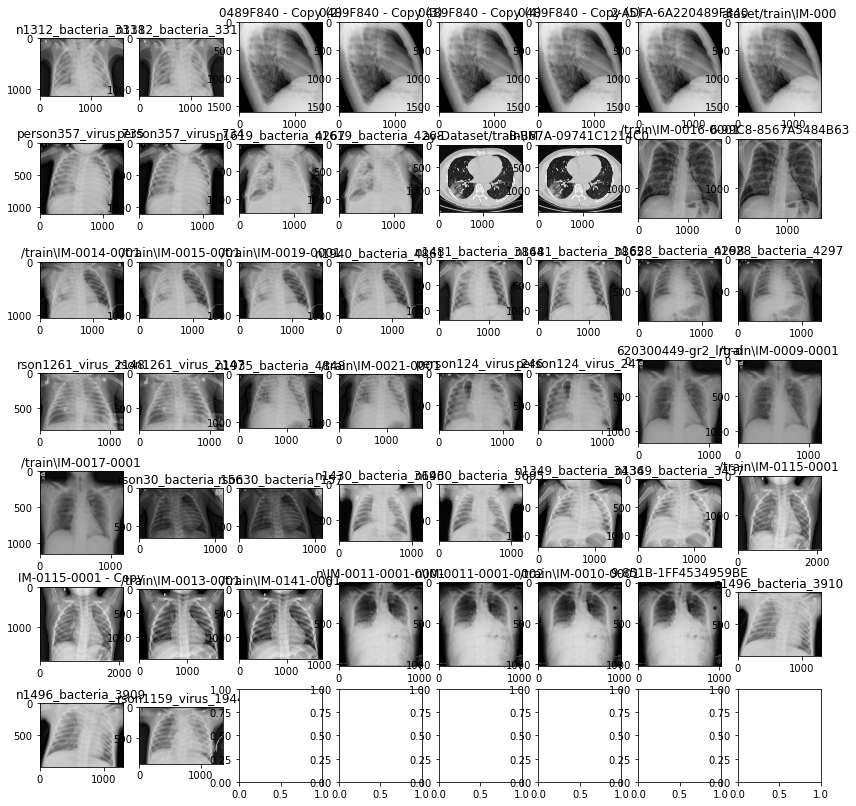

In [10]:
iwork.show_images_in_df(final_names,19)

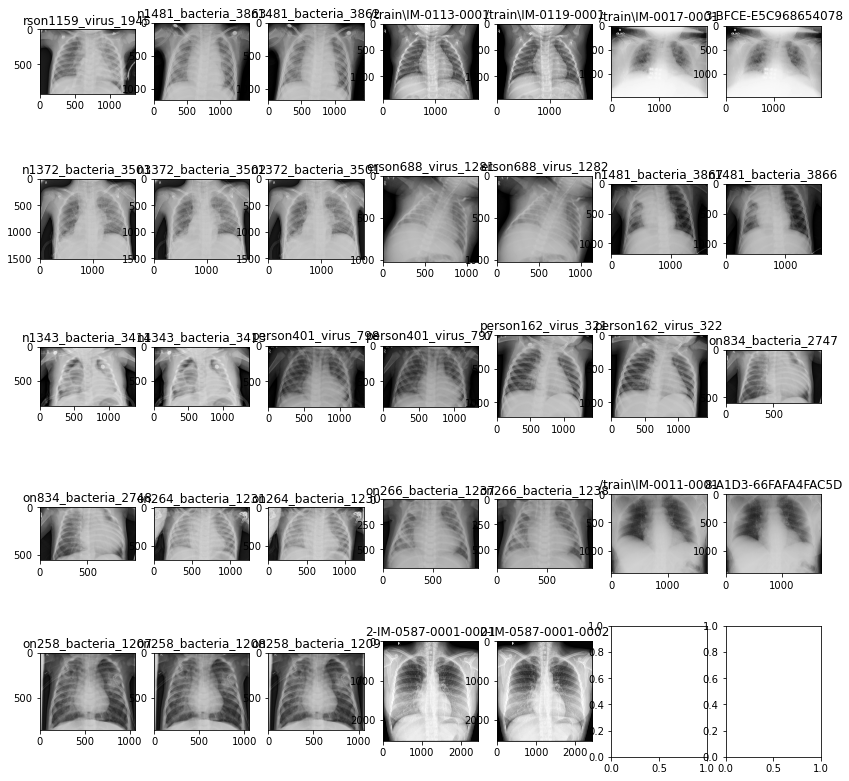

In [11]:
final_names = []
for image_string in wierd_images_list[50:]:
    final_names.append(os.path.join(origin_folder, image_string))
iwork.show_images_in_df(final_names,19)

Interesting, some of our duplicated pictures appear to have been triplicated e.g. person258_bacteria_1208.jpeg	and person258_bacteria_1209.jpeg seem to be two from a triplicate , so we get two of the same.In the end neither humans or a potential machine learning algorithm will be perfect, but together, the two can do better than either alone. For good measure we could definitely pull out the triplicated pictures. Two is wierd, three plus is just getting ridiculous....,someone might notice, and claim we are lazy.  

NB: If you are working with someone who codes, they could do all the above steps, and just pull these out without bothering you. 

But let's see the another way to look: (mse = mean squared error)

In [12]:
alt_found = iwork.find_close_images(origin_folder,60,190)


***
 Output:  72  potential duplicate image pairs in  5322  total images.
 At compression level 60 and mse 190


In [13]:
alt_found

,twinA?,twinB?,mse
0,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.701667
1,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.701667
2,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000
3,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000
4,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000
...,...,...,...
67,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000
68,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000
69,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000
70,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,D:/my_academia/ncs/Coronahack-Chest-XRay-Datas...,0.000000



***
 Output:  72  potential duplicate image pairs in  5322  total images.
 At compression level 60 and mse 190


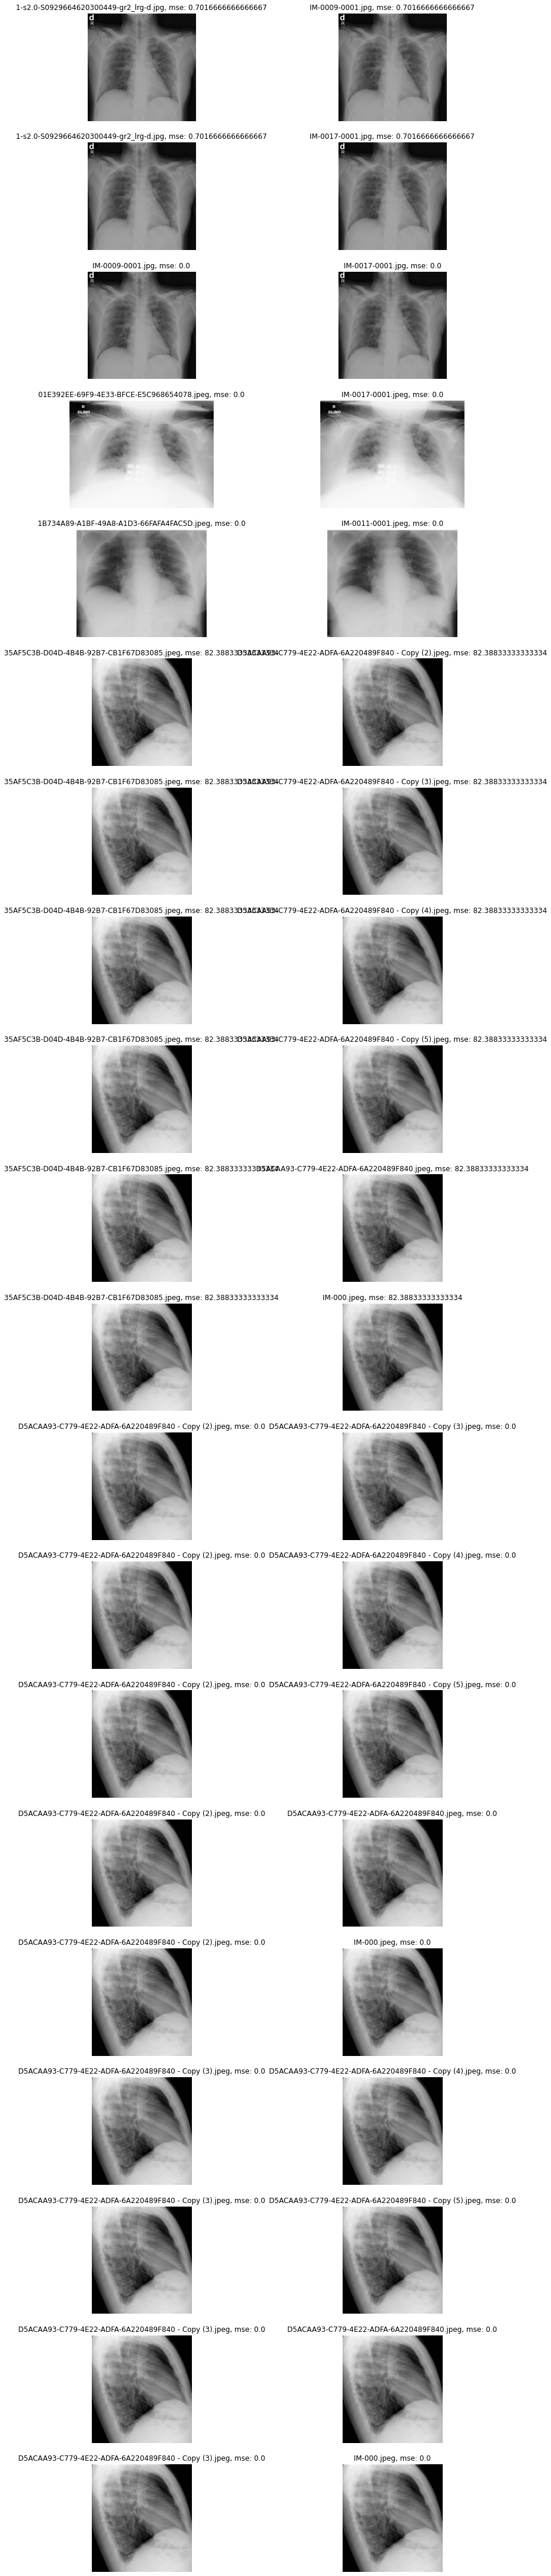

In [14]:
alt_show = iwork.show_close_images(origin_folder,60,190)

## Finding outlier images

Now let's see if we really have all similarly shot chest Xrays, or some nonsense flew in. We can use one of several methods with cleanX:

In [15]:
# in a chest Xray we expect more black on top and fewer bright values
# - the abdomen is bigger than the neck, let's see where that is not true
upper_lower_returned = iwork.find_sample_upper_greater_than_lower(origin_folder, 10)
# let's look at a sample of upper part of images and see if there are outliers
upper_scan_returned = iwork.find_by_sample_upper(origin_folder, 10, 200)
#let's compare each image to an average of all images, and take the most different
tiny_image_different = iwork.find_tiny_image_differences(origin_folder, percentile=1)

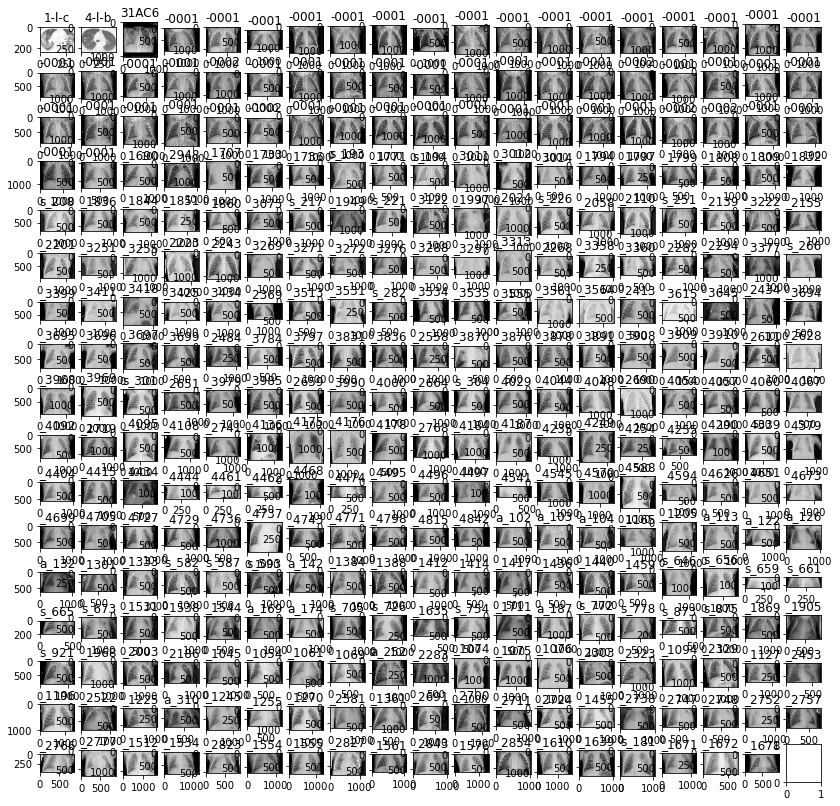

In [16]:
wierd_images1 = upper_lower_returned[upper_lower_returned.which_greater == 'upper more']
iwork.show_images_in_df(wierd_images1.images.to_list(), 5)
#wierd_images_list = wierd_images.images.to_list()
#iwork.show_images_in_df(wierd_images_list, 25)

In [17]:
# how many is that?
len(wierd_images1.images.to_list())

322

Ouch, that's a lot of images...and some are just people with thier hands up... on the other hand, I'd rather check these 322 carefully, than check over 5000 carefully. Let's try another way...

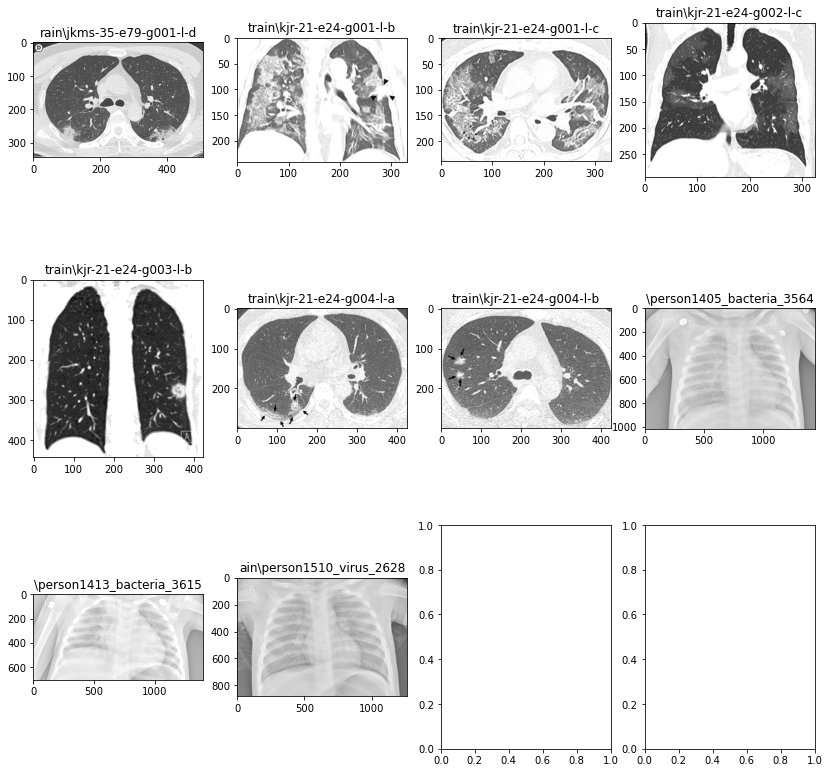

In [18]:
wierd_images = upper_scan_returned[upper_scan_returned['where'] != 'less']
wierd_images_list = wierd_images.images.to_list()
iwork.show_images_in_df(wierd_images_list, 25)

OK, those are definitely outliers we probably wwant to pull. CTs are not going to feed the same neural net as chest X-rays...and those last three there, did someone put kids in the flouroscopy machines? If we want to do an algorithm for adults with COVID, let's just pull those too.  

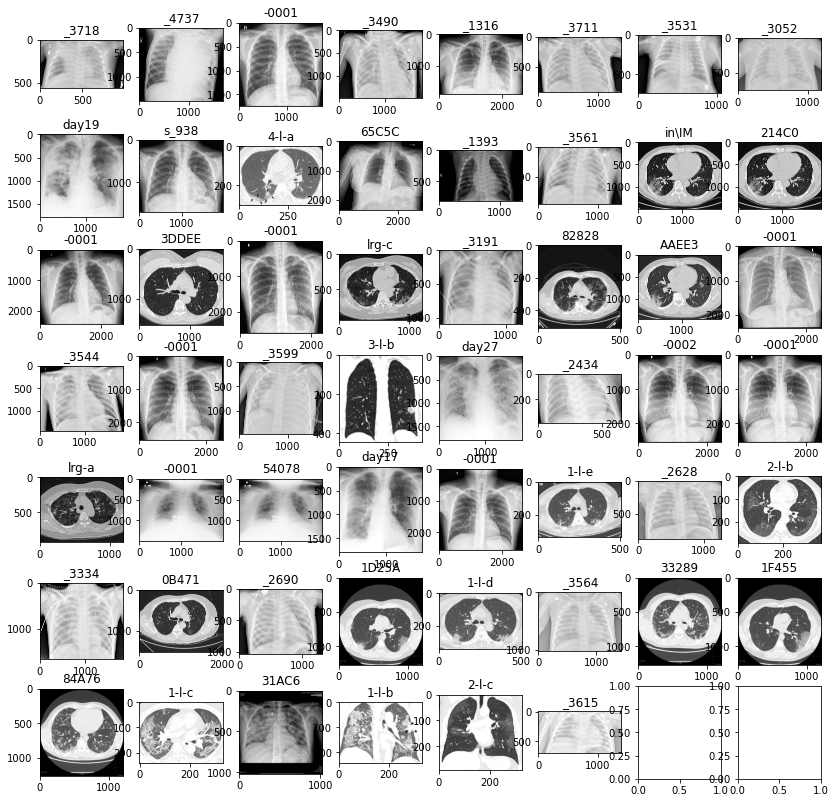

In [19]:
# OK, let's see where our shape is really off
tiny_image_different = iwork.find_tiny_image_differences(origin_folder, percentile=1)
one_percenters = tiny_image_different[tiny_image_different.results == 'mismatch']
iwork.show_images_in_df(one_percenters.images.to_list(), 5)

# What else can I do?

CleanX has lots of functionality. Some is showcased in the other notebooks. Here [with classes](https://github.com/drcandacemakedamoore/cleanX/blob/main/workflow_demo/classes_workflow.ipynb) and here  [without classes](https://github.com/drcandacemakedamoore/cleanX/blob/main/workflow_demo/no_classes_workflow_example.ipynb). 